In [348]:
import pickle
from tqdm.auto import tqdm
import os
from trec_car import read_data
from collections import defaultdict
import urllib
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim import utils, matutils
from numpy import array, vstack, float32
import time
import justext
import requests
from requests.adapters import HTTPAdapter
import random
import urllib3
urllib3.disable_warnings()
import numpy as np
import itertools
from bert_serving.client import BertClient
from tokenizers import BertWordPieceTokenizer
from scipy.spatial.distance import cosine
import re

raw_data_home = "/ssd2/arthur/TRECCAR"
data_home = "/ssd2/arthur/TRECCAR/data"

In [326]:
def get_level2(headings, parents, hierarchy=[], depth=1):
    """extract all leaves or level2 headings from an hierarchy"""
    all_headings = []
    for i in headings:
        cannonical_name = parents+"/"+i[0].headingId
        if len(i[1]) < 1 or depth == 2:
            all_headings.append((cannonical_name, i[0].heading, hierarchy + [i[0].heading]))
        all_headings += (get_level2(i[1], cannonical_name, hierarchy + [i[0].heading], depth=depth+1))
    return all_headings

def generate_docs_offset(doc_file):
    """Generates a dictionary with the offset for each doc in the docs file. Opens the dictionary if it already exists"""
    offset_path = doc_file + ".offset"
    if os.path.isfile(offset_path):
        logging.info("Already found offset dict at {}. skipping".format(offset_path))
        return pickle.load(open(offset_path, 'rb'))
    offset_dict = dict()
    pbar = tqdm(total=config.corpus_size, desc="Generating doc offset dictionary")
    empty_docs = 0
    with open(doc_file, encoding="utf-8", errors="surrogateescape") as inf:
        location = 0
        line = True
        while line:
            line = inf.readline()
            try:
                doc_id, _ = line.split("\t")
            except (IndexError, ValueError):
                print(line)
                empty_docs +=1
                continue
            offset_dict[doc_id] = location
            location = inf.tell()
            pbar.update()
    pickle.dump(offset_dict, open(offset_path, 'wb'))
    print(len(offset_dict))
    return offset_dict

def get_content(doc_id, doc_file, offset_dict):
    """ Given a doc_id, the doc_file path and the dictionary computer at generate_docs_offset(), returns the doc text"""
    offset = offset_dict[doc_id]
    with open(doc_file) as f:
        f.seek(offset)
        doc = f.readline()
    if doc_file.endswith("bert"):
        return eval(doc.split("\t")[1].strip())
    else:
        doc_text = "\t".join(doc.split("\t")[1:])
        return doc_text.strip()


In [668]:
# get subtopics for each topic
sample_queries = pickle.load(open("sample_queries.pkl", 'rb'))
topics_path = os.path.join(raw_data_home, "benchmarkY1/benchmarkY1-train/train.pages.cbor-outlines.cbor")
topics_to_use = []
topic_id = 0
leaf_subtopics = defaultdict(lambda:set())
for page in tqdm(read_data.iter_annotations(open(topics_path, 'rb')), total=117):
#     if page.page_name not in sample_queries.keys():
#         continue
    topics_to_consider = get_level2(page.deep_headings_list(), page.page_id, hierarchy=[page.page_name])
    topics_to_use += topics_to_consider
    for title, _, hierarchy in topics_to_consider:
        _hierarchy = title.split("/")
        if len(_hierarchy) < 2:
            continue
        if len(_hierarchy) > 3:
            title = "/".join(_hierarchy[:3])
        leaf_subtopics[page.page_name].add(title)

In [323]:
# Get relevant for each subtopic
qrel_path = os.path.join(raw_data_home, "benchmarkY1/benchmarkY1-train/train.pages.cbor-hierarchical.qrels")
assert os.path.isfile(qrel_path)
relevant_docs_per_subtopic = defaultdict(lambda:set())
for line in open(qrel_path):  
    title, _, doc_id, _ = line.split(" ")
    hierarchy = title.split("/")
    topic = urllib.parse.unquote(hierarchy[0])[7:]
    if len(hierarchy) > 3:
        title = "/".join(hierarchy[:3])
    relevant_docs_per_subtopic[title].add(doc_id)
relevant_docs_per_subtopic = dict(relevant_docs_per_subtopic)
print(len(relevant_docs_per_subtopic))

1727


In [8]:
#Load Word2Vec (no need anymore. Stick with BERT)
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import logging

corpus_path = os.path.join(data_home, "docs/docs.tsv") #TREC-formatted
docs_offset_dict = generate_docs_offset(corpus_path)
print("loading w2v")
try:
    w2v_vectors = KeyedVectors.load(datapath("/ssd2/arthur/googlenews_keyedvectors"), mmap="r")
except:
    w2v_vectors = KeyedVectors.load_word2vec_format(datapath("/ssd2/arthur/GoogleNews-vectors-negative300.bin.gz"), binary=True)
w2v_vectors.init_sims()

loading w2v


In [684]:
#Compute BERT embedding for subtopics, using the Bert-as-a-service docker image running at DeepIR
bc = BertClient(check_length=False)
subtopics_vectors = dict()
subtopics_bert_vectors = dict()
subtopics_text = defaultdict(lambda: [])
subtopics_text_full = defaultdict(lambda: [])
stop_words = stopwords.words('english')
batch_subtopics = []
pbar = tqdm(desc="loading embeddings", total=98)
tokenizer = BertWordPieceTokenizer("/ssd2/arthur/bert-axioms/tokenizer/bert-base-uncased-vocab.txt", lowercase=True)
for topic in leaf_subtopics.keys():
    for subtopic in leaf_subtopics[topic]:
        pbar.update()
        try:
            rel_docs = relevant_docs_per_subtopic[subtopic]
        except:
            continue
        for doc_id in rel_docs:
            doc_text = get_content(doc_id, corpus_path, docs_offset_dict)
            doc = [w.lower() for w in word_tokenize(doc_text)]
            subtopics_text_full[subtopic].append(doc_text)
            doc = [w for w in doc if (w.isalpha() and w not in stop_words and w in w2v_vectors.vocab)]
            subtopics_text[subtopic]+=doc
        vectors = vstack(list(w2v_vectors[term] for term in subtopics_text[subtopic] if term in w2v_vectors.vocab))
        subtopics_vectors[subtopic] = matutils.unitvec(vectors.mean(axis=0)).astype(float32)
        batch_subtopics.append(subtopic)
clean_docs = [x.tokens[1:-1] for x in tokenizer.encode_batch([" ".join(subtopics_text_full[subtopic]) for subtopic in batch_subtopics])]
all_docs = [x[:512] for x in clean_docs]
bert_vectors = bc.encode(all_docs, is_tokenized=True)
subtopics_bert_vectors = {k:v for k, v in zip(batch_subtopics, bert_vectors)}

In [651]:
!ls ../src/server

app  get_data.py  __pycache__  server.py


In [692]:
pickle.dump(subtopics_bert_vectors, open("../src/server/subtopic_vectors.pkl", 'wb'))

In [544]:
#Manually annotated
actually_bad_urls = ["hawaiilibrary.net", "theinfolist.com", "peoplemaven.com", "wiki2.org", 
                     "zoo-hoo.com", "museumstuff.com", "answers.com", "oilfieldwiki.com", "wikimili.com", 
                     "winentrance.com", "Paralumnun.com", "wikinfo.org", "jambase.com", "newworldencyclopedia.org",
                    "wikiwand.com", "medievalwarfare.info", "tripatlas.com", "alchetron.com", "wikivisually.com", "printfriendly.com",
                    "afropedea.org", "conservapedia.com", "kids.kiddle.co", "thefreedictionary.com", "dictionary.sensagent.com", "artistopia.com",
                    "academickids.com", "jewishvirtuallibrary.org", "classictvhits.com", "findwords.info", "pediapress.com",
                    "memim.com", "i2osig.org", "absoluteastronomy.com", "wikishire.co.uk", "biographybase.com",
                    "knowledgewiki.org", "en.turkcewiki.org", "gpedia.com", "heart-disease.health-cares.net", "sheppardsoftware.com", "wikimapia.org",
                     "us.wow.com", "citizendium.org", "mondolatino.eu", "jiskha.com", "footballyears.net", "encyclopedia.thefreedictionary.com",
                     "wp.wiki-wiki.ru", "wiki.phantis.com", "roadnow.com", "getwiki.net", "marspc.co.il", "self.gutenberg.org",
                     "wikibin.org", "vacilando.org", "statemaster.com", "wikiwix.com", "daviddarling.info", "sciencedaily.com",
                     "wikipedia.org", "wikimili.com", "wikiversity.org", "thefullwiki.org", "petrowiki.org", "wikizero.com", "wikidoc.org", 
                     "taggedwiki.zubiaga.org", "wiki.seg.org", "youtube.com", "everything.explained.today",  "self.guttenberg.org"]
blacklist = " ".join(["-site:{}".format(x) for x in actually_bad_urls])

In [12]:
# Send bing requests

subscription_key = "7ff9c011b5124834b3bcde7600adcc6b"
try:
    bing_URLs = pickle.load(open("bing_URLs.pkl", 'rb'))
    bing_snippets = pickle.load( open("bing_snippets.pkl", 'rb'))
    print("not recomputing this")
except:
    bing_URLs = defaultdict(lambda:[])
    bing_snippets = defaultdict(lambda:[])
    ran_queries = 0
    flag = False
    pbar = tqdm(total=50)
    for topic in sample_queries:
        for query in sample_queries[topic]:
            pbar.update()
            search_url = "https://api.cognitive.microsoft.com/bing/v7.0/search"
            headers = {"Ocp-Apim-Subscription-Key": subscription_key, "BingAPIs-Market":"en-US, en-GB", "Accept-Language":"en-US, en-GB"}
            params = {"q": query +' -filetype:pdf' + " " + blacklist, "textDecorations": True, "textFormat": "HTML", "count": 25, "responseFilter": "Webpages", "cc":"US"}
            response = requests.get(search_url, headers=headers, params=params)
            response.raise_for_status()
            search_results = response.json()
            bing_snippets[topic].append((query, [x['snippet'] for x in  search_results['webPages']['value']]))
            bing_URLs[topic].append((query, [x['url'] for x in  search_results['webPages']['value']]))
            docs = [x['url'] for x in  search_results['webPages']['value']]
            ran_queries+=1
    pickle.dump(dict(bing_snippets), open("bing_snippets.pkl", 'wb'))
    pickle.dump(dict(bing_URLs), open("bing_URLs.pkl", 'wb'))

not recomputing this


In [269]:
# Load the exact same docs and URLs as in the previous experiments. Even if not final. Makes it easier to compare.
old_df = pd.read_csv(open("w2v_scores_clean_bing.csv"))
print(old_df.shape)
old_urls = defaultdict(lambda:defaultdict(lambda:list()))
for line in old_df.iterrows():
    old_urls[line[1].topic][line[1].query].append(line[1].doc_url)

(4864, 9)


In [467]:
relevance_table = pd.read_csv("/ssd/nirmalr/scores_with_judgments.csv")

In [510]:
relevances = defaultdict(lambda:defaultdict(lambda:0.0))
for line in relevance_table.iterrows():
    subtopic = line[1].subtopic
    url = line[1].doc_url
    if url == '  ':
        continue
    if line[1]['relevant?'] == "1" or line[1]['relevant?'] == "0":
        relevances[url][subtopic] = line[1]['relevant?']

In [347]:
RUN_THIS = True

unreadable_pages = {'http://self.gutenberg.org/articles/Radiocarbon_dating', 'https://medlineplus.gov/irritablebowelsyndrome.html'}


def clean_page(html_content):
    # Return a clean page using justext. 
    paragraphs = [x.text for x in justext.justext(html_content, justext.get_stoplist("English")) if not x.is_boilerplate]
    total_text_len = sum([len(x.split()) for x in paragraphs])
    if total_text_len == 0:
        return (0, [])
    return (total_text_len, paragraphs)


if RUN_THIS:
    try:
        full_document_texts
    except:
        full_document_texts = dict()
    try:
        documents_paragraphs
    except:
        documents_paragraphs = dict()
    queries_to_keep = pickle.load(open("queries_to_keep.pkl", 'rb'))
    pbar = tqdm(total=25*10, desc="fetching URL contents")
    for topic in bing_URLs: #For each topic
        print(topic)
    #         for query in queries_to_keep[topic]:
    #             urls = dict(bing_URLs[topic])[query]
        for _, urls in old_urls[topic].items(): #iterate over previous URLs. skip the ones unused.
            for url in set(urls):
                pbar.update()
                if url in documents_paragraphs or url in unreadable_pages:
                    continue
                s = requests.Session()
                #Pretend to be a MAC running Safari
                s.headers.update({'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) AppleWebKit/601.3.9 (KHTML, like Gecko) Version/9.0.2 Safari/601.3.9'})
                adapter = HTTPAdapter(max_retries=1)
                s.mount('https://', adapter)
                s.mount('http://', adapter)
                try:
                    page_content = s.get(url, verify=False, timeout=10).text
                except requests.ConnectionError as e:
                    print("Could not fetch page {}".format(url))
                    unreadable_pages.add(url)
                    continue
                full_document_texts[url] = page_content
                documents_paragraphs[url] = clean_page(page_content)
    pickle.dump(full_document_texts, open("full_document_texts.pkl", "wb"))
    pickle.dump(documents_paragraphs, open("documents_paragraphs.pkl", "wb"))
else:
    full_document_texts = pickle.load(open("full_document_texts.pkl", "rb"))
    documents_paragraphs = pickle.load(open("documents_paragraphs.pkl", "rb"))
    

Radiocarbon dating considerations
Irritable bowel syndrome
Noise-induced hearing loss
Genetically modified organism
Research in lithium-ion batteries


In [665]:
len(subtopic_keywords)

0

In [680]:
subtopics_text_full[subtopic]

[]

In [691]:
subtopic_keywords = dict()

for topic in leaf_subtopics:
    for subtopic in leaf_subtopics[topic]:
        keywords = get_keywords_from_subtopic(subtopic)
        subtopic_keywords[subtopic] = keywords
pickle.dump(subtopic_keywords, open("subtopic_keywords.pkl", 'wb'))
pickle.dump(subtopic_keywords, open("../src/server/subtopic_keywords.pkl", 'wb'))

In [677]:
pattern = re.compile('([^\s\w]|_)+')

def get_keywords_from_subtopic(subtopic):
    if subtopic in subtopic_keywords: 
        return subtopic_keywords[subtopic]

    stop_words = set(stopwords.words('english'))
    clean_text = pattern.sub(''," ".join(subtopics_text_full[subtopic]))
    return set([w.lower() for w in clean_text.split() if w.lower() not in stop_words])
url_keywords = dict()
def get_keywords_from_url(url):
    if url in url_keywords:
        return url_keywords[url]
    stop_words = set(stopwords.words('english'))
    if len(documents_paragraphs[url][1]) == 0:
        return set()
    clean_text = pattern.sub(''," ".join(documents_paragraphs[url][1]))
    return set([w.lower() for w in clean_text.split() if w.lower() not in stop_words])

def get_term_overlap(url, subtopic, threshold = None):
    subtopic_terms = get_keywords_from_subtopic(subtopic)
    url_terms = get_keywords_from_url(url)
    if not threshold:
        return len(subtopic_terms.intersection(url_terms))/len(subtopic_terms)
    else:
        return len(subtopic_terms.intersection(url_terms))/len(subtopic_terms) > threshold

In [709]:
def evalulate(bert_sims, relevances, threshold):
    scores = []
    labels = []
    for url in relevances:
        for subtopic in relevances[url]:
            labels.append(int(relevances[url][subtopic]))
            scores.append(bert_sims[url][subtopic])
    binary_scores = [x>threshold for x in scores]
    from sklearn.metrics import average_precision_score, accuracy_score, roc_auc_score, f1_score, recall_score
    prec = average_precision_score(labels, binary_scores)
    acc = accuracy_score(labels, binary_scores)
    ROC = roc_auc_score(labels, scores)
    recall = recall_score(labels, binary_scores)
    f1 = f1_score(labels, binary_scores)
    number_of_ones = np.sum(binary_scores)
    print(number_of_ones)
    return(prec, acc, ROC, recall, f1)
evalulate(bert_sims, relevances, 0.775)

713


(0.5365426770934412,
 0.7208883553421368,
 0.7470324118678822,
 0.7006472491909385,
 0.6506386175807664)

In [596]:
len(np.arange(0.5, 0.95, 0.025)) * 4 * 6

432

In [608]:
POOLING_FUNCTION == np.max

True

In [662]:
leaf_subtopics[topic]

{'enwiki:Radiocarbon%20dating%20considerations/Atmospheric%20variation/Effect%20of%20climatic%20cycles',
 'enwiki:Radiocarbon%20dating%20considerations/Atmospheric%20variation/Effects%20of%20human%20activity',
 'enwiki:Radiocarbon%20dating%20considerations/Atmospheric%20variation/Variations%20in%20%20production',
 'enwiki:Radiocarbon%20dating%20considerations/Contamination',
 'enwiki:Radiocarbon%20dating%20considerations/Isotopic%20fractionation',
 'enwiki:Radiocarbon%20dating%20considerations/Reservoir%20effects/Hard%20water%20effect',
 'enwiki:Radiocarbon%20dating%20considerations/Reservoir%20effects/Hemisphere%20effect',
 'enwiki:Radiocarbon%20dating%20considerations/Reservoir%20effects/Island%20effect',
 'enwiki:Radiocarbon%20dating%20considerations/Reservoir%20effects/Marine%20effect',
 'enwiki:Radiocarbon%20dating%20considerations/Reservoir%20effects/Volcanoes'}

In [697]:
bert_sims.keys()

dict_keys([])

In [ ]:
bert_sims['https://www.britannica.com/science/atmospheric-pressure']

In [707]:
# Actual scoring


def sim(paragraph_emb, subtopic):
    subtopic_emb = subtopics_bert_vectors[subtopic]
    return (1 - cosine(paragraph_emb, subtopic_emb))

w2v_times = []
bert_times = []
w2v_sims = dict()
printed_docs = set()
bert_sims = dict()

pattern = re.compile('([^\s\w]|_)+')
stop_words = set(stopwords.words('english'))

#     "MIN_TERM_COUNT": 50,
#     "OVERLAP_THRESHOLD": 20,
#     "POOLING_FUNCTION" : "max",
MIN_TERM_COUNT = 50
OVERLAP_THRESHOLD = .2
POOLING_FUNCTION = np.max

# def run(MIN_TERM_COUNT=50, OVERLAP_THRESHOLD=0.2, POOLING_FUNCTION = np.max):
urls = []
last_query = None
for count, line in enumerate(old_df.iterrows()): #Iterate over old dataset. 
    query = line[1]["query"]
    if (query != last_query and last_query!=None) or count == len(old_df)-1: # Check if every url for this query has been loaded.
#         break
        last_query = query
        bert_start = time.time()
        unique_urls = list(OrderedDict.fromkeys(urls))
        offsets = dict()

        for i, url in enumerate(unique_urls):
            url_len = len(documents_paragraphs[url][1]) if url in documents_paragraphs else 0
            if i == 0:
                offsets[url] = (0, url_len)
            else:
                offsets[url] = (offsets[unique_urls[i-1]][1], offsets[unique_urls[i-1]][1]+url_len)

        too_short_paragraphs = {x for x in unique_urls if x in documents_paragraphs and documents_paragraphs[x][0] < MIN_TERM_COUNT}

        embedable_urls = [x for x in unique_urls if x not in too_short_paragraphs and x in documents_paragraphs]
        paragraphs = [documents_paragraphs[x][1] for x in embedable_urls]
        all_paragraphs = [item for sublist in paragraphs for item in sublist]
        tokens_all_paragraphs = [x.tokens for x in tokenizer.encode_batch(all_paragraphs)]
        embeddings = bc.encode(tokens_all_paragraphs, is_tokenized=True)
        for url, subtopic in itertools.product(urls, leaf_subtopics[topic]):
            if url not in bert_sims:
                bert_sims[url] = dict()
            if url in too_short_paragraphs or url not in documents_paragraphs: #either too short or not available
                bert_sims[url][subtopic] = 0.0
                continue
            if subtopic in bert_sims[url]:
                continue
            term_coverage = get_term_overlap(url, subtopic)
            if term_coverage < OVERLAP_THRESHOLD:
                bert_sims[url][subtopic] = 0.0
                continue
            url_embeddings = embeddings[offsets[url][0]:offsets[url][1]]
            sims = [sim(x, subtopic) for x in url_embeddings]
            bert_sims[url][subtopic] = POOLING_FUNCTION(sims)
        bert_times.append(time.time() - bert_start)
        urls = []
    url = line[1]["doc_url"]
    topic = line[1].topic
    if last_query == None:
        last_query = query
    urls.append(url)
# return bert_sims



In [626]:
Fine tune
pbar = tqdm(total = len(np.arange(0.5, 0.95, 0.025)) * 4 * 6 * 3)
print("   \t   \t  \t   \t AP\tACC\tROCAUC\tREC\tF1")
results = []
for POOLING_FUNCTION in [np.max, np.mean, np.median]:
    for MIN_TERM_COUNT in [20, 50, 75, 100]:
        for OVERLAP_THRESHOLD in [.1, .2, .25, .3, .4, .5, .6, .7]:
            bert_sims = run(MIN_TERM_COUNT, OVERLAP_THRESHOLD, POOLING_FUNCTION)
            for SIM_THRESHOLD in np.arange(0.5, 0.95, 0.025):
                prec, acc, ROC, recall, f1 = evalulate(bert_sims, relevances, SIM_THRESHOLD)
                if POOLING_FUNCTION == np.max:
                    pool = "max"
                elif POOLING_FUNCTION == np.mean:
                    pool = "mean"
                else:
                    pool = "median"
                results.append({"Pooling function":pool,"MIN_TERM_COUNT":MIN_TERM_COUNT, "OVERLAP_THRESHOLD": OVERLAP_THRESHOLD, "SIM_THRESHOLD": SIM_THRESHOLD, "average_precision":prec, "accuracy":acc, "ROC_AUC":ROC, "recall":recall, "F1 Score":f1})
                print("{}\t{}\t{:.3f}\t{}\t{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}".format(MIN_TERM_COUNT, OVERLAP_THRESHOLD, SIM_THRESHOLD, pool, prec, acc, ROC, recall, f1))
                pbar.update()
df = pd.DataFrame(results)

In [654]:
subtopic

'enwiki:Research%20in%20lithium-ion%20batteries/Electrolyte/Copper'

In [618]:
df.corr()

,F1 Score,MIN_TERM_COUNT,OVERLAP_THRESHOLD,ROC_AUC,SIM_THRESHOLD,accuracy,average_precision,recall
F1 Score,1.000000e+00,-4.670663e-19,-2.074297e-17,2.204772e-14,-7.393289e-01,-3.735906e-01,9.301925e-01,9.586245e-01
MIN_TERM_COUNT,-4.670663e-19,1.000000e+00,1.128060e-15,0.000000e+00,7.125910e-19,-9.362429e-18,7.009469e-19,1.361306e-17
OVERLAP_THRESHOLD,-2.074297e-17,1.128060e-15,1.000000e+00,-3.184502e-15,-3.164702e-17,-1.459068e-17,-1.556494e-18,2.418290e-17
ROC_AUC,2.204772e-14,0.000000e+00,-3.184502e-15,1.000000e+00,-1.505626e-14,9.489261e-15,-6.586358e-14,-1.867257e-14
SIM_THRESHOLD,-7.393289e-01,7.125910e-19,-3.164702e-17,-1.505626e-14,1.000000e+00,7.917225e-01,-4.823595e-01,-8.409604e-01
accuracy,-3.735906e-01,-9.362429e-18,-1.459068e-17,9.489261e-15,7.917225e-01,1.000000e+00,-2.524181e-02,-6.051397e-01
average_precision,9.301925e-01,7.009469e-19,-1.556494e-18,-6.586358e-14,-4.823595e-01,-2.524181e-02,1.000000e+00,8.101957e-01
recall,9.586245e-01,1.361306e-17,2.418290e-17,-1.867257e-14,-8.409604e-01,-6.051397e-01,8.101957e-01,1.000000e+00


In [627]:
df.max()

F1 Score              0.64163
MIN_TERM_COUNT            100
OVERLAP_THRESHOLD         0.7
Pooling function       median
ROC_AUC              0.746406
SIM_THRESHOLD           0.925
accuracy             0.696279
average_precision    0.500055
recall               0.915858
dtype: object

In [638]:
best_results_df.min()[["MIN_TERM_COUNT", "OVERLAP_THRESHOLD", "Pooling function", "SIM_THRESHOLD"]]

MIN_TERM_COUNT          20
OVERLAP_THRESHOLD      0.1
Pooling function       max
SIM_THRESHOLD        0.775
dtype: object

In [634]:
best_results_df = df[(df["F1 Score"]==df.max()["F1 Score"]) & (df["ROC_AUC"] == df.max()["ROC_AUC"])]

In [645]:
best_results_df.shape

(96, 9)

In [648]:
best_results_df[best_results_df.accuracy==best_results_df.max()["accuracy"]]

,F1 Score,MIN_TERM_COUNT,OVERLAP_THRESHOLD,Pooling function,ROC_AUC,SIM_THRESHOLD,accuracy,average_precision,recall
11,0.64163,20,0.10,max,0.746406,0.775,0.662065,0.499728,0.815534
29,0.64163,20,0.20,max,0.746406,0.775,0.662065,0.499728,0.815534
47,0.64163,20,0.25,max,0.746406,0.775,0.662065,0.499728,0.815534
65,0.64163,20,0.30,max,0.746406,0.775,0.662065,0.499728,0.815534
83,0.64163,20,0.40,max,0.746406,0.775,0.662065,0.499728,0.815534
101,0.64163,20,0.50,max,0.746406,0.775,0.662065,0.499728,0.815534
119,0.64163,20,0.60,max,0.746406,0.775,0.662065,0.499728,0.815534
137,0.64163,20,0.70,max,0.746406,0.775,0.662065,0.499728,0.815534
155,0.64163,50,0.10,max,0.746406,0.775,0.662065,0.499728,0.815534
173,0.64163,50,0.20,max,0.746406,0.775,0.662065,0.499728,0.815534


In [640]:
best_results_df.max()[["recall", "average_precision", "accuracy"]]

recall               0.815534
average_precision    0.499728
accuracy             0.662065
dtype: object

In [622]:
df.sort_values(by=["F1 Score","ROC_AUC"], ascending = False)

,F1 Score,MIN_TERM_COUNT,OVERLAP_THRESHOLD,Pooling function,ROC_AUC,SIM_THRESHOLD,accuracy,average_precision,recall
11,0.641630,20,0.10,max,0.746406,0.775,0.662065,0.499728,0.815534
29,0.641630,20,0.20,max,0.746406,0.775,0.662065,0.499728,0.815534
47,0.641630,20,0.25,max,0.746406,0.775,0.662065,0.499728,0.815534
65,0.641630,20,0.30,max,0.746406,0.775,0.662065,0.499728,0.815534
83,0.641630,20,0.40,max,0.746406,0.775,0.662065,0.499728,0.815534
101,0.641630,20,0.50,max,0.746406,0.775,0.662065,0.499728,0.815534
119,0.641630,50,0.10,max,0.746406,0.775,0.662065,0.499728,0.815534
137,0.641630,50,0.20,max,0.746406,0.775,0.662065,0.499728,0.815534
155,0.641630,50,0.25,max,0.746406,0.775,0.662065,0.499728,0.815534
173,0.641630,50,0.30,max,0.746406,0.775,0.662065,0.499728,0.815534


In [592]:
prec, acc, ROC, recall, f1 = evalulate(bert_sims, relevances, SIM_THRESHOLD)
print("{}\t{}\t{}\t{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}".format(MIN_TERM_COUNT, OVERLAP_THRESHOLD, SIM_THRESHOLD, prec, acc, ROC, recall, f1))

20	0.3	0.75	0.4872	0.6333	0.7464	0.8786	0.6400


In [ ]:

# for topic in bing_URLs:
#     for query, urls in old_urls[topic].items():
# #     for query in queries_to_keep[topic]:
# #         urls = dict(bing_URLs[topic])[query]
#         w2v_start = time.time()
#         for url in urls:
#             if url not in document_texts:
#                 continue
#             if url not in w2v_sims:
#                 w2v_sims[url] = dict()
#             clean_text = pattern.sub('', document_texts[url])
#             doc = [w.lower() for w in clean_text.split() if w.lower() not in stop_words and w.lower() in w2v_vectors.vocab]
#             read_urls += 1
#             vectors = array([w2v_vectors[w] for w in doc])
#             if len(doc) > 0:
#                 mean_vector = matutils.unitvec(vectors.mean(axis=0)).astype(float32)
#             for subtopic in leaf_subtopics[topic]:
#                 if len(doc) == 0:
#                     w2v_sims[url][subtopic] = 0
#                     continue
#                 w2v_sims[url][subtopic] = 1 - cosine(mean_vector, subtopics_vectors[subtopic])
#                 if w2v_sims[url][subtopic] > 0.95 and url not in printed_docs:
#                     printed_docs.add(url)
#         w2v_times.append(time.time()-w2v_start)
        
#         bert_start = time.time()
#         valid_urls = [x for x in urls if x in document_texts]
        
#         tokens = {url: x.tokens for url, x in zip(valid_urls, tokenizer.encode_batch([document_texts[url] for url in valid_urls]))}

#         mask_docs = set()
#         used_urls = []
#         all_docs = []
#         for url, x in tokens.items():
#             if len(x) > 2:
#                 used_urls.append(url)
#                 if len(x) > 512:
#                     all_docs.append(x[len(x)//2 - 512//2 : len(x)//2 + 512//2])
#                 else:
#                     all_docs.append(x)
#             else:
#                 mask_docs.add(url)
#         embeddings = bc.encode(all_docs, is_tokenized=True)
#         bert_vectors = dict(zip(used_urls, embeddings))
#         for url, subtopic in itertools.product(valid_urls, leaf_subtopics[topic]):
#             if url not in bert_sims:
#                 bert_sims[url] = dict()
#             if url in mask_docs:
#                 bert_sims[url][subtopic] = 0.0
#                 continue
#             url_vec = bert_vectors[url]
#             subtopic_vec = subtopics_bert_vectors[subtopic]
#             bert_sims[url][subtopic]  = 1 - cosine(url_vec, subtopic_vec)
#         bert_times.append(time.time() - bert_start)
#         pbar.update()
# print("Average W2V time:{}\nAverage BERT time:{}\ntotal URLS:{}".format(np.mean(w2v_times), np.mean(bert_times), read_urls))


In [572]:
evalulate(bert_sims, relevances)

0.5355005117589763 0.7148859543817527 0.7470324118678822


In [485]:
bert_sims.keys()

dict_keys(['https://www.lithiumion-batteries.com/', 'https://electronics.howstuffworks.com/everyday-tech/lithium-ion-battery.htm', 'https://batteryuniversity.com/learn/archive/is_lithium_ion_the_ideal_battery', 'https://www.cei.washington.edu/education/science-of-solar/battery-technology/', 'https://www.alibaba.com/showroom/lithium-ion-battery.html', 'https://www.wikihow.com/Maintain-Lithium-Battery', 'https://www.techrepublic.com/blog/five-apps/five-tips-for-extending-lithium-ion-battery-life/', 'https://www.popularmechanics.com/science/energy/a30089061/freeze-car-battery/', 'https://economictimes.indiatimes.com/companies-line-up-plans-for-li-battery-production/articleshow/66946557.cms', 'https://www.bloomberg.com/news/articles/2019-04-03/battery-reality-there-s-nothing-better-than-lithium-ion-coming-soon'])

In [486]:
bert_sims['https://www.lithiumion-batteries.com/']

{'enwiki:Research%20in%20lithium-ion%20batteries/Cathode/Graphene%20oxide%20coated%20sulfur': 0.7516600489616394,
 'enwiki:Research%20in%20lithium-ion%20batteries/Electrolyte/Additive': 0.7697935700416565,
 'enwiki:Research%20in%20lithium-ion%20batteries/Anode/Nanowire': 0.7826288342475891,
 'enwiki:Research%20in%20lithium-ion%20batteries/Electrolyte/Perfluoropolyether': 0.7919175624847412,
 'enwiki:Research%20in%20lithium-ion%20batteries/Electrolyte/Superhalogen': 0.7885335087776184,
 'enwiki:Research%20in%20lithium-ion%20batteries/Cathode/Transition-metal%20Oxides': 0.6960793733596802,
 'enwiki:Research%20in%20lithium-ion%20batteries/Cathode/Nanophosphate': 0.8465643525123596,
 'enwiki:Research%20in%20lithium-ion%20batteries/Anode/Carbon': 0.7151471972465515,
 'enwiki:Research%20in%20lithium-ion%20batteries/Cathode/Lithium': 0.7843942046165466,
 'enwiki:Research%20in%20lithium-ion%20batteries/Cathode/Seawater': 0.8392777442932129,
 'enwiki:Research%20in%20lithium-ion%20batteries/Elec

In [310]:
sum(old_df.doc_url == new_df.doc_url) == old_df.shape[0]

True

In [311]:
cols = []
for line in old_df.iterrows():
    query = line[1]['query']
    topic = line[1]['topic']
    url = line[1]['doc_url']
    subtopic = line[1]['subtopic']
    if url not in document_texts:
        w2v_score = bert_score = 0.0
    else:
        w2v_score = w2v_sims[url][subtopic]
        bert_score = bert_sims[url][subtopic]
    rel_w2v = 1 if w2v_score > 0.7 else 0
    rel_bert = 1 if bert_score > 0.5 else 0
    cols.append({"query":query,"topic": topic, "subtopic": subtopic, "doc_url":url, "w2v_score": w2v_score, "bert_score": bert_score, "relevant_w2v":rel_w2v, "relevant_bert":rel_bert})


# for topic in tqdm(bing_URLs):
# #     for query in queries_to_keep[topic]:
# #         for url in dict(bing_URLs[topic])[query][:10]:
#     for query, urls in old_urls.items():
#         for url in urls:
# #             if url not in document_texts:
# #                 continue
#             for subtopic in leaf_subtopics[topic]:
#                 if url not in document_texts:
#                     w2v_score = bert_score = 0
#                     rel_bert = rel_w2v = 0
#                 else:
#                     w2v_score = w2v_sims[url][subtopic]
#                     bert_score = bert_sims[url][subtopic]
#                     rel_w2v = 1 if w2v_score > 0.7 else 0
#                     rel_bert = 1 if bert_score > 0.5 else 0
#                 cols.append({"query":query,"topic": topic, "subtopic": subtopic, "doc_url":url, "w2v_score": w2v_score, "bert_score": bert_score, "relevant_w2v":rel_w2v, "relevant_bert":rel_bert})
# import pandas as pd
new_df = pd.DataFrame(cols)
new_df = new_df[["query", "topic", "subtopic", "doc_url", "relevant_w2v", "w2v_score", "relevant_bert", "bert_score"]]
new_df.shape[0] == old_df.shape[0]
sum(old_df.doc_url == new_df.doc_url) == old_df.shape[0]

True

In [314]:
new_df.to_csv("new_parser.csv")

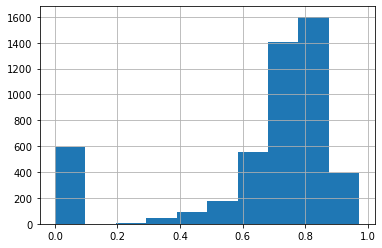

In [312]:
new_df.w2v_score.hist()

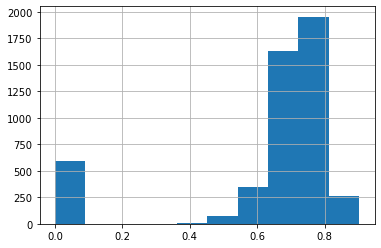

In [313]:
new_df.bert_score.hist()

In [456]:
for i in document_texts:
    if "youtube" in i:
        print(i)
        break

https://www.youtube.com/watch?v=5YckIUU1d44


In [460]:
bing_snippets.keys()

dict_keys(['Radiocarbon dating considerations', 'Irritable bowel syndrome', 'Noise-induced hearing loss', 'Genetically modified organism', 'Research in lithium-ion batteries'])

In [ ]:
url = "https://www.youtube.com/watch?v=Z2oLA35YcuQ"

In [480]:
i = 1
for i in range(10):
    for x, y in zip(bing_URLs["Radiocarbon dating considerations"][i][1], bing_snippets["Radiocarbon dating considerations"][i][1]):
        if x == "https://www.youtube.com/watch?v=Z2oLA35YcuQ":
            print(y)

Learn complete Physics for IIT JEE for free. Browse through topics and tons of solved examples to practice solving easy and tough problems.


In [582]:
df.head()

,query,topic,subtopic,doc_url,relevant_w2v,w2v_score,relevant_bert,bert_score
0,Atmospheric variation,Radiocarbon dating considerations,enwiki:Radiocarbon%20dating%20considerations/R...,https://www.britannica.com/science/atmospheric...,1,0.812793,1,0.803919
1,Atmospheric variation,Radiocarbon dating considerations,enwiki:Radiocarbon%20dating%20considerations/C...,https://www.britannica.com/science/atmospheric...,1,0.739722,1,0.748227
2,Atmospheric variation,Radiocarbon dating considerations,enwiki:Radiocarbon%20dating%20considerations/R...,https://www.britannica.com/science/atmospheric...,1,0.827240,1,0.830137
3,Atmospheric variation,Radiocarbon dating considerations,enwiki:Radiocarbon%20dating%20considerations/R...,https://www.britannica.com/science/atmospheric...,1,0.801240,1,0.827089
4,Atmospheric variation,Radiocarbon dating considerations,enwiki:Radiocarbon%20dating%20considerations/I...,https://www.britannica.com/science/atmospheric...,1,0.825004,1,0.824394
